In [1]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from scipy.spatial import distance_matrix


In [2]:
path_to_query_adata = "/mnt/sata2/Analysis_Alex_2/perturb4_no_baysor/final_object_corrected.h5ad"
query_adata = sc.read(path_to_query_adata)

In [3]:
import sys
sys.path.insert(0, '/home/amonell/piloting/scvi-tools/src')
print("Added to path:", sys.path[0])

import scvi.external.resolvi as RESOLVI
import scvi
print("Importing from:", scvi.external.resolvi.__file__)

Added to path: /home/amonell/piloting/scvi-tools/src
Importing from: /home/amonell/piloting/scvi-tools/src/scvi/external/resolvi/__init__.py


In [4]:
#sc.pp.subsample(query_adata, fraction=0.1)

In [5]:
query_adata

AnnData object with n_obs × n_vars = 810225 × 480
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'total_transcripts', 'nuclear_transcripts', 'cytoplasmic_transcripts', 'nuclear_transcript_percentage', 'topic', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'Class', 'reference_crypt_villi', 'villi_number', 'peyers', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'crypt_villi_axis', 'epithelial_distance', 'epithelial_distance_clipped', 'epithelial_distance_transformed', 'guide_rnas', 'cell_types', 'cluster_cellcharter', 'epithelial_distance_scaled'
    uns: '_cellcharter', '_scvi_manager_uuid', '_scvi_uuid', 'cluster_cellcharter_color

In [6]:
RESOLVI.RESOLVI.setup_anndata(query_adata, labels_key="cell_types", layer="raw", batch_key="batch", perturbation_key='guide_rnas', control_perturbation='Other cells')

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/home/amonell/piloting/scvi-tools/src/scvi/data/fields/_dataframe_field.py:187: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [7]:
supervised_resolvi = RESOLVI.RESOLVI(
    query_adata, semisupervised=True
)

Debug: Starting perturbation detection...
Debug: Found categorical covariates registry: field_keys: !!python/tuple
- guide_rnas
mappings:
  guide_rnas: !!python/object/apply:numpy.core.multiarray._reconstruct
    args:
    - !!python/name:numpy.ndarray ''
    - !!python/tuple
      - 0
    - !!binary |
      Yg==
    state: !!python/tuple
    - 1
    - !!python/tuple
      - 14
    - !!python/object/apply:numpy.dtype
      args:
      - O8
      - false
      - true
      state: !!python/tuple
      - 3
      - '|'
      - null
      - null
      - null
      - -1
      - -1
      - 63
    - false
    - - Other cells
      - sgCcl3
      - sgCcl5
      - sgCcr2
      - sgCcr5
      - sgCcr7
      - sgCcr9
      - sgCd19
      - sgCx3cl1
      - sgCxcl10
      - sgCxcr3
      - sgCxcr4
      - sgCxcr6
      - sgXcl1
n_cats_per_key: !!python/tuple
- 14

Debug: Field keys found: ('guide_rnas',)
Debug: Trying to auto-detect perturbation from field keys...
Debug: Checking field key: guide_r

In [8]:


priors = supervised_resolvi.compute_dataset_dependent_priors()
print(priors)


{'background_ratio': 0.00067531277, 'median_distance': 372.9849853515625, 'mean_log_counts': 5.433722, 'std_log_counts': 0.8109416}


In [9]:
supervised_resolvi.module.guide.downsample_counts_mean = float(
    supervised_resolvi.module.guide.downsample_counts_mean
)
supervised_resolvi.module.guide.downsample_counts_std = float(
    supervised_resolvi.module.guide.downsample_counts_std
)
supervised_resolvi.train(
    max_epochs=100,
    check_val_every_n_epoch=1,
    lr=3e-4
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

--- Debugging Perturbation Shift ---
Decoder px_rate (before shift) stats: mean=0.5790, std=0.5391, min=0.0099, max=9.9315
Shift net delta stats: mean=0.0123, std=0.2558, min=-1.2765, max=1.4669
Applying shift for 2 perturbed cells out of 512 cells.
Log px_rate (base) stats: mean=-0.9029, std=0.8757, min=-4.6202, max=2.2957
Log px_rate (after shift) stats: mean=-0.9029, std=0.8759, min=-4.6202, max=2.2957
Decoder px_rate (after exp) stats: mean=0.5791, std=0.5393, min=0.0099, max=9.9315
mean_nb stats: mean=0.2984, std=0.2644, min=0.0056, max=4.3736
background stats: mean=0.2881, std=0.2308, min=0.0174, max=1.6168
Final mean_poisson stats: mean=0.5865, std=0.4677, min=0.0245, max=5.4004
--------------------------------------
--- Debugging Perturbation Shift ---
Decoder px_rate (before shift) stats: mean=0.5790, std=0.5402, min=0.0103, max=11.4601
Shift net delta stats: mean=0.0124, std=0.2569, min=-1.3997, max=1.6107
Applying shift for 2 perturbed cells out of 512 cells.
Log px_rate (ba


Detected KeyboardInterrupt, attempting graceful shutdown ...


--- Debugging Perturbation Shift ---
Decoder px_rate (before shift) stats: mean=0.5958, std=2.6639, min=0.0002, max=118.0786
Shift net delta stats: mean=-0.7913, std=1.1748, min=-5.7534, max=5.1974
Applying shift for 1 perturbed cells out of 512 cells.
Log px_rate (base) stats: mean=-3.0517, std=2.0789, min=-8.7134, max=4.7714
Log px_rate (after shift) stats: mean=-3.0535, std=2.0802, min=-9.4113, max=4.7714
Decoder px_rate (after exp) stats: mean=0.5958, std=2.6639, min=0.0001, max=118.0786
mean_nb stats: mean=0.6029, std=2.6555, min=0.0002, max=130.3435
background stats: mean=0.0006, std=0.0004, min=0.0000, max=0.0035
Final mean_poisson stats: mean=0.6035, std=2.6556, min=0.0003, max=130.3465
--------------------------------------
--- Debugging Perturbation Shift ---
Decoder px_rate (before shift) stats: mean=0.5567, std=2.4037, min=0.0001, max=94.1027
Shift net delta stats: mean=-0.7728, std=1.1589, min=-6.0296, max=5.1877
Applying shift for 1 perturbed cells out of 512 cells.
Log p

In [10]:
celltype = 'CD8 T Cells'

In [13]:
cell_indices = np.where(query_adata.obs['guide_rnas'] == 'sgCd19')[0]
effects_cells = supervised_resolvi.get_perturbation_effects(
    indices=cell_indices
)

Debug - device target: cuda:0
Debug - x device: cuda:0
Debug - ind_x device: cuda:0
Debug - library device: cuda:0
Debug - y device: cuda:0
Debug - batch_index device: cuda:0
Debug - cat_covs device: cuda:0
Debug - x_n device: cuda:0
Debug - distances_n device: cuda:0
Debug - x_input device: cuda:0
Debug - batch_input device: cuda:0
Debug - categorical_input devices: []
Debug - z_encoder device: cuda:0
Debug - device target: cuda:0
Debug - x device: cuda:0
Debug - ind_x device: cuda:0
Debug - library device: cuda:0
Debug - y device: cuda:0
Debug - batch_index device: cuda:0
Debug - cat_covs device: cuda:0
Debug - x_n device: cuda:0
Debug - distances_n device: cuda:0
Debug - x_input device: cuda:0
Debug - batch_input device: cuda:0
Debug - categorical_input devices: []
Debug - z_encoder device: cuda:0
Debug - device target: cuda:0
Debug - x device: cuda:0
Debug - ind_x device: cuda:0
Debug - library device: cuda:0
Debug - y device: cuda:0
Debug - batch_index device: cuda:0
Debug - cat_c

,guide_rnas
aaaackdi-1,0
aaaaddii-1,0
aaaafjep-1,0
aaaaklej-1,0
aaaakpai-1,0
...,...
oinanmfc-1,0
oinaojph-1,0
oinbbbgh-1,0
oinbfame-1,0


In [25]:
pd.DataFrame(list(zip(query_adata.obs['guide_rnas'].values, query_adata.obsm['_scvi_extra_categorical_covs']['guide_rnas'].values)), columns = ['celltype', 'perturb_number'])

,celltype,perturb_number
0,Other cells,0
1,Other cells,0
2,Other cells,0
3,Other cells,0
4,Other cells,0
...,...,...
810220,Other cells,0
810221,Other cells,0
810222,Other cells,0
810223,Other cells,0


In [ ]:
check with not just sgCD19 cells to see if the effects are correct per perturbation

In [17]:
effects_cells.index = effec

,2200002D01Rik,AW112010,Acta2,Adam15,Adam17,Adam2,Adam23,Adam9,Adamdec1,Adgre1,...,Xcr1,Xist,YFP,Zdhhc14,eGFP,mCherry,mt-Co1,mt-Cytb,tag_BFP,tdTomato
perturbation_1,0.132045,-0.038405,-0.047150,-0.349046,0.558020,0.013371,0.463749,-0.097299,-0.617139,-0.516396,...,-0.433928,0.024502,-0.044137,0.407630,-0.185486,0.352359,-0.011106,-0.302596,0.323419,0.531866
perturbation_2,0.217465,-0.698755,-0.537247,-0.993746,0.320533,0.114081,0.278505,-0.145187,-1.106195,-0.801564,...,-0.752116,0.096085,-0.413865,0.212029,-0.699589,0.382117,0.137465,-0.042754,0.136359,0.523827
perturbation_3,-0.100522,-0.302917,-0.091290,-0.420384,0.485923,0.100717,-0.162657,-0.425748,-1.117927,-0.954758,...,-0.778456,-0.082387,-0.690161,-0.103879,-0.350373,0.323711,0.206088,0.241013,-0.123343,0.190661
perturbation_4,-0.704553,-0.163474,0.210975,0.119416,0.656985,-0.106706,0.153364,-0.385991,-0.258536,0.317547,...,-0.111462,-0.285766,-0.378184,0.270330,-0.104020,-0.019803,-0.175764,-0.230219,0.392882,-0.042867
perturbation_5,-0.241440,-0.043730,0.342310,-0.051581,0.336989,-0.061248,-0.610754,0.107968,-0.088860,0.320612,...,0.517619,-0.213868,0.177648,-0.056946,0.158588,0.253145,-0.254305,-0.013885,0.238061,-0.096038
perturbation_6,0.265132,-0.079644,0.204211,-0.369293,0.510791,0.096069,-0.105850,0.195494,-0.541977,-0.013194,...,0.199247,0.229931,0.316941,-0.358381,0.314738,-0.218070,-0.030586,0.138241,0.278026,0.014444
perturbation_7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
perturbation_8,-0.345931,-0.332318,-0.053317,-0.503866,0.125398,-0.028664,-0.038871,-0.006993,-0.269516,-0.279919,...,0.126152,0.283208,0.021989,0.253542,0.031877,0.495002,0.131245,-0.125297,-0.086733,-0.170769
perturbation_9,-0.806728,-0.413226,0.002079,0.000735,0.113292,0.232961,-0.677402,-0.202912,-0.769651,0.013753,...,-0.354638,-0.671619,-0.640184,0.031457,-0.251786,-0.197091,0.082183,-0.030824,0.784622,0.277029
perturbation_10,-0.262620,0.096559,-0.750117,0.180311,0.006178,-0.110306,-0.032434,-0.041806,-1.055438,0.393072,...,0.251184,0.316991,-0.167936,-0.114020,0.003497,0.458471,-0.152678,-0.141687,0.326533,-0.164648


In [14]:
corrected_expression = supervised_resolvi.get_normalized_expression(
    adata=query_adata
)


In [15]:
query_adata.layers['resolvi_expression'] = corrected_expression

In [16]:
effects_cells[['Perturbation_0', 'Perturbation_1', 'Perturbation_2', 'Perturbation_3', 'Perturbation_4', 'Perturbation_5', 'Perturbation_6', 'Perturbation_7', 'Perturbation_8', 'Perturbation_9','Perturbation_10', 'Perturbation_11', 'Perturbation_12']]

,Perturbation_0,Perturbation_1,Perturbation_2,Perturbation_3,Perturbation_4,Perturbation_5,Perturbation_6,Perturbation_7,Perturbation_8,Perturbation_9,Perturbation_10,Perturbation_11,Perturbation_12
perturbation_1,-1.086352,5.107813,-1.318382,-0.610399,-5.585457,0.679384,2.474708,3.529340,-1.249693,0.088212,-0.522525,-0.230343,-1.606781
perturbation_2,0.528198,-0.629937,0.275235,-0.624587,-5.768835,5.401816,0.130487,2.636188,-1.101618,-0.374845,0.568374,-0.075114,0.151467
perturbation_3,-0.644811,2.285532,-0.847863,-0.891403,-7.059850,2.080713,2.665134,5.007749,-1.393631,-0.634309,0.477516,-0.407517,-1.900431
perturbation_4,-0.018009,2.271649,-0.707304,-0.671086,-5.577393,0.349995,3.908333,3.072823,-0.572269,-0.036503,1.297087,-0.083422,-1.095611
perturbation_5,0.668962,0.570586,0.592451,0.142352,-3.555957,-0.081469,1.051861,1.100947,-0.177540,-0.037216,0.750814,0.722515,-0.266423
perturbation_6,-0.145527,0.910087,0.278441,-0.156486,-3.694905,0.876311,1.271376,1.039745,0.159311,0.146213,0.449622,0.462453,-0.941504
perturbation_7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
perturbation_8,0.597895,0.671086,0.192929,0.853915,-3.412991,1.076117,1.108901,1.719603,-0.820913,-0.190060,0.618462,-0.157730,-0.011224
perturbation_9,5.257761,-0.162133,-0.424239,-0.600909,-4.740173,0.542735,1.502014,1.065898,-1.271230,0.058145,0.867223,-0.176437,0.041638
perturbation_10,0.724182,-0.647695,0.679032,-0.311360,-4.668068,1.714048,1.271276,1.986323,-0.559614,-0.108138,2.218675,0.330221,-1.184055


In [32]:
effects_cells[['Upp1', 'Cxcl9', 'Ifng', 'Il7r', 'Il21r', 'Ccr6']]

,Upp1,Cxcl9,Ifng,Il7r,Il21r,Ccr6
perturbation_1,0.566522,0.561586,0.396677,-1.040849,0.657849,-0.273883
perturbation_2,-0.407199,0.752291,0.421437,-0.225969,0.814082,0.049667


/tmp/ipykernel_3913027/2261608128.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby('mapped_batch').mean().reset_index()


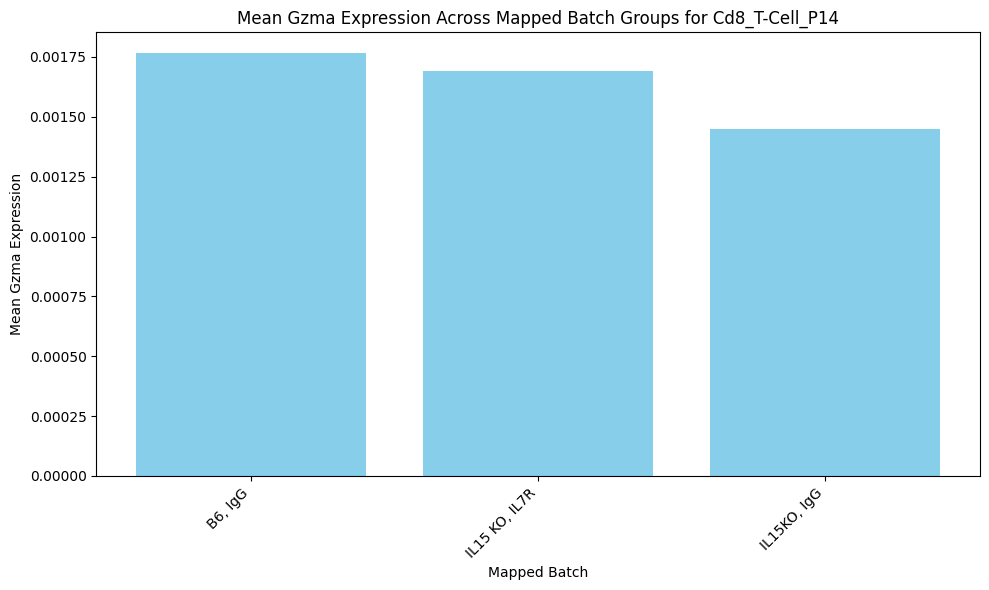

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_gene_expression_in_resolvi(gene_name, resolvi_predicted='Enterocyte_1'):
    # Filter the data for the specific 'resolvi_predicted' category
    filtered_indices = query_adata.obs['resolvi_predicted'] == resolvi_predicted
    gene_expression = query_adata.layers['resolvi_expression'][filtered_indices, query_adata.var.index == gene_name].flatten()
    mapped_batch_values = query_adata.obs.loc[filtered_indices, 'mapped_batch'].values

    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({
        f'{gene_name}_expression': gene_expression,
        'mapped_batch': mapped_batch_values
    })

    # Group by mapped_batch and calculate mean expression
    grouped_df = df.groupby('mapped_batch').mean().reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(grouped_df['mapped_batch'], grouped_df[f'{gene_name}_expression'], color='skyblue')
    plt.xlabel('Mapped Batch')
    plt.ylabel(f'Mean {gene_name} Expression')
    plt.title(f'Mean {gene_name} Expression Across Mapped Batch Groups for {resolvi_predicted}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage
plot_gene_expression_in_resolvi('Gzma', resolvi_predicted=celltype)


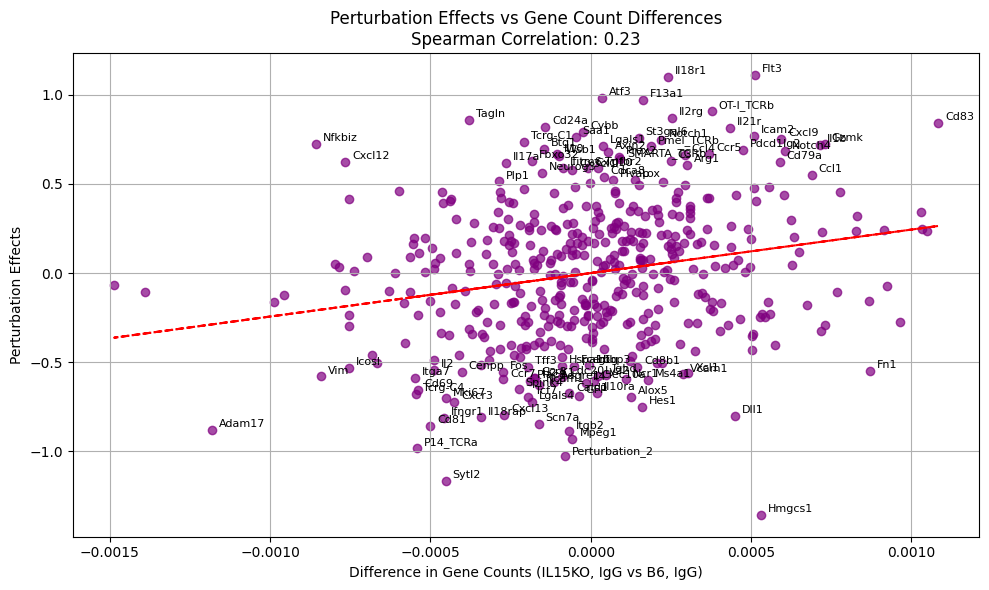

In [34]:

from scipy.stats import spearmanr
import numpy as np

perturbation_effects = effects_cells.loc['perturbation_2'].values
# Calculate the difference in gene counts between the two batches
batch1_counts = query_adata[(query_adata.obs['mapped_batch'] == 'IL15KO, IgG') & (query_adata.obs['resolvi_predicted'] == celltype)].layers['resolvi_expression'].mean(axis=0)
batch2_counts = query_adata[(query_adata.obs['mapped_batch'] == 'B6, IgG') & (query_adata.obs['resolvi_predicted'] == celltype)].layers['resolvi_expression'].mean(axis=0)
gene_count_diff = batch1_counts - batch2_counts

# Filter perturbation effects where values are less than 0.05
valid_indices = np.abs(perturbation_effects) >= 0
gene_count_diff_filtered = gene_count_diff[valid_indices]
perturbation_effects_filtered = perturbation_effects[valid_indices]

# Get gene names for annotation
gene_names = query_adata.var.index.values if hasattr(query_adata.var, "index") else np.arange(len(perturbation_effects))
gene_names_filtered = gene_names[valid_indices]

# Calculate Spearman correlation
spearman_corr, _ = spearmanr(gene_count_diff_filtered, perturbation_effects_filtered)

# Plot the perturbation effects against the gene count differences
plt.figure(figsize=(10, 6))
plt.scatter(gene_count_diff_filtered, perturbation_effects_filtered, color='purple', alpha=0.7)

# Annotate each point with the gene name (optionally, only annotate top N by abs effect for clarity)
N_annotate = 100  # annotate top 10 by absolute perturbation effect
if len(gene_names_filtered) > N_annotate:
    top_indices = np.argsort(np.abs(perturbation_effects_filtered))[-N_annotate:]
else:
    top_indices = np.arange(len(gene_names_filtered))
for i in top_indices:
    plt.annotate(gene_names_filtered[i], 
                 (gene_count_diff_filtered[i], perturbation_effects_filtered[i]),
                 textcoords="offset points", xytext=(5,2), ha='left', fontsize=8, color='black')

# Add line of best fit
m, b = np.polyfit(gene_count_diff_filtered, perturbation_effects_filtered, 1)
plt.plot(gene_count_diff_filtered, m * gene_count_diff_filtered + b, color='red', linestyle='--')

plt.xlabel('Difference in Gene Counts (IL15KO, IgG vs B6, IgG)')
plt.ylabel('Perturbation Effects')
plt.title(f'Perturbation Effects vs Gene Count Differences\nSpearman Correlation: {spearman_corr:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:


# 4. Get uncertainty estimates (multiple samples)
effects_with_uncertainty = supervised_resolvi.get_perturbation_effects(
    n_samples=100,
    return_mean=False  # Returns (n_samples, n_perturbations, n_genes)
)

# Calculate mean and standard deviation
effects_mean = effects_with_uncertainty.mean(axis=0)
effects_std = effects_with_uncertainty.std(axis=0)

# 5. Return as numpy array instead of DataFrame
effects_numpy = supervised_resolvi.get_perturbation_effects(
    return_numpy=True
)


perturbation_1 - Top upregulated genes:
Olfm4      0.160932
S100a4     0.146479
Cd74       0.140134
Il17a      0.136326
Lgr5       0.132411
Jchain     0.131299
Meg3       0.128033
Neurog3    0.125850
Mzb1       0.125348
Scn7a      0.124500
Name: perturbation_1, dtype: float32

perturbation_1 - Top downregulated genes:
Muc13    -0.125823
mt-Co1   -0.117608
Rbp2     -0.101208
Fabp2    -0.093622
Apoa1    -0.074589
Slc9a3   -0.073016
Ifngr1   -0.072394
Il18     -0.068574
Pcsk5    -0.060879
Ifngr2   -0.060798
Name: perturbation_1, dtype: float32

perturbation_2 - Top upregulated genes:
Upp1      0.180055
Cd74      0.155298
H2-Aa     0.086877
Itga6     0.075242
Ccl20     0.074872
Cd8b1     0.061757
Irf8      0.057358
H2-Eb1    0.054356
Il1a      0.053360
Atp1b1    0.047624
Name: perturbation_2, dtype: float32

perturbation_2 - Top downregulated genes:
Tyrobp   -0.097767
Muc13    -0.093395
C1qb     -0.084836
Csf1r    -0.083398
C1qa     -0.076835
Il2rg    -0.075518
Pecam1   -0.072680
Acta2   

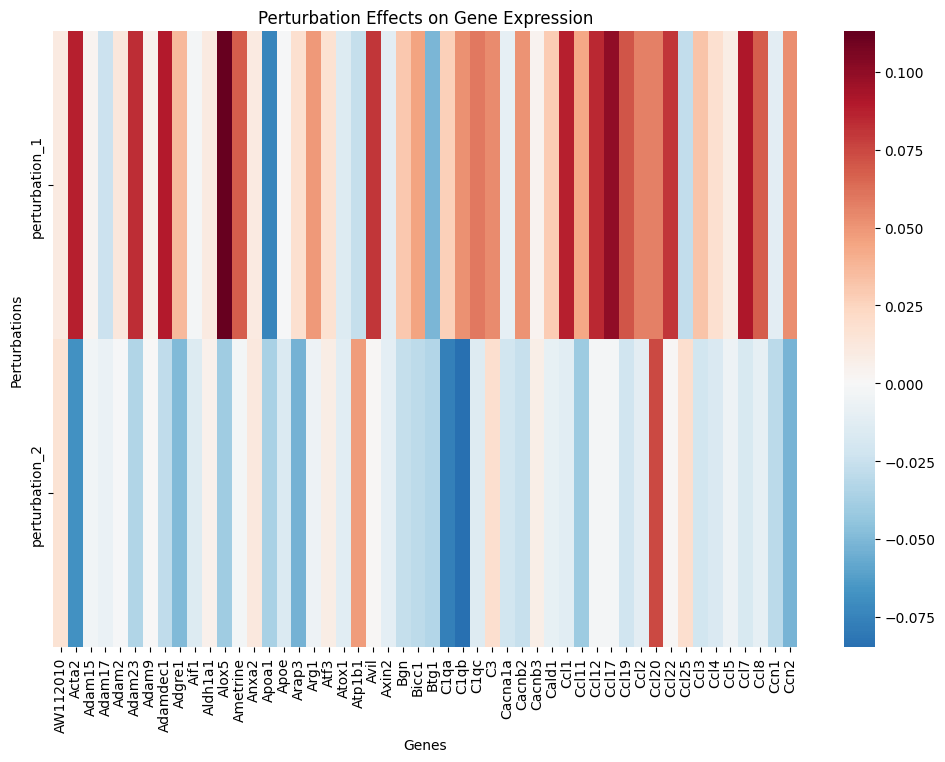

In [9]:
# Extract effects
effects_df = supervised_resolvi.get_perturbation_effects()

# Find genes most affected by each perturbation
for perturbation in effects_df.index:
    # Get top 10 upregulated genes
    top_up = effects_df.loc[perturbation].nlargest(10)
    print(f"\n{perturbation} - Top upregulated genes:")
    print(top_up)
    
    # Get top 10 downregulated genes  
    top_down = effects_df.loc[perturbation].nsmallest(10)
    print(f"\n{perturbation} - Top downregulated genes:")
    print(top_down)

# Visualize effects
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of perturbation effects
plt.figure(figsize=(12, 8))
sns.heatmap(effects_df.iloc[:, :50], cmap='RdBu_r', center=0)  # First 50 genes
plt.title('Perturbation Effects on Gene Expression')
plt.xlabel('Genes')
plt.ylabel('Perturbations')
plt.show()
